# Student Dropout Prediction

## 1. Preparation

### 1.1. Library Preparation

In [79]:
import os
import re
import json
import warnings
import phik # Phi-K corr. matrix
import joblib
import time

import pandas as pd
import sqlalchemy as sqa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce # Leave one out encoder

from dython.nominal import associations # Cramer's V corr. matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,  VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

### 1.2. Data Preparation

In [80]:
df = pd.read_csv('data/data.csv', sep = ';')
df.tail()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate
4423,1,10,1,9773,1,1,152.0,22,38,37,...,0,6,6,6,13.000000,0,12.7,3.7,-1.70,Graduate


## 2. Data Understanding

### 2.1. Check Null Values and Data Types

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

### 2.2. Check Simple Data Distribution
We may see abnormal values here (typo, outlier, minus values that should not be possible on some columns, etc)

Sometimes also useful for binning values (e.g. `width_bucket` if using PostgreSQL)

In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital_status,4424.0,1.178571,0.605747,1.00,1.00,1.000000,1.000000,6.000000
Application_mode,4424.0,18.669078,17.484682,1.00,1.00,17.000000,39.000000,57.000000
Application_order,4424.0,1.727848,1.313793,0.00,1.00,1.000000,2.000000,9.000000
Course,4424.0,8856.642631,2063.566416,33.00,9085.00,9238.000000,9556.000000,9991.000000
Daytime_evening_attendance,4424.0,0.890823,0.311897,0.00,1.00,1.000000,1.000000,1.000000
Previous_qualification,4424.0,4.577758,10.216592,1.00,1.00,1.000000,1.000000,43.000000
Previous_qualification_grade,4424.0,132.613314,13.188332,95.00,125.00,133.100000,140.000000,190.000000
Nacionality,4424.0,1.873192,6.914514,1.00,1.00,1.000000,1.000000,109.000000
Mothers_qualification,4424.0,19.561935,15.603186,1.00,2.00,19.000000,37.000000,44.000000
Fathers_qualification,4424.0,22.275316,15.343108,1.00,3.00,19.000000,37.000000,44.000000


### 2.3. Check Possible Values

Compare cell output with [this reference](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) or files in `data/column_values` in case there's an unknown value

In [83]:
for col in df.columns:
    if df[col].nunique() <= 10:
        print(f'{col}:', df[col].unique(), f'({df[col].nunique()} values)')
    elif df[col].nunique() == 1:
        print(f'{col}: USELESS (1 value)')
    else:
        print(f'{col}: TOO MANY ({df[col].nunique()} values)')

Marital_status: [1 2 4 3 5 6] (6 values)
Application_mode: TOO MANY (18 values)
Application_order: [5 1 2 4 3 6 9 0] (8 values)
Course: TOO MANY (17 values)
Daytime_evening_attendance: [1 0] (2 values)
Previous_qualification: TOO MANY (17 values)
Previous_qualification_grade: TOO MANY (101 values)
Nacionality: TOO MANY (21 values)
Mothers_qualification: TOO MANY (29 values)
Fathers_qualification: TOO MANY (34 values)
Mothers_occupation: TOO MANY (32 values)
Fathers_occupation: TOO MANY (46 values)
Admission_grade: TOO MANY (620 values)
Displaced: [1 0] (2 values)
Educational_special_needs: [0 1] (2 values)
Debtor: [0 1] (2 values)
Tuition_fees_up_to_date: [1 0] (2 values)
Gender: [1 0] (2 values)
Scholarship_holder: [0 1] (2 values)
Age_at_enrollment: TOO MANY (46 values)
International: [0 1] (2 values)
Curricular_units_1st_sem_credited: TOO MANY (21 values)
Curricular_units_1st_sem_enrolled: TOO MANY (23 values)
Curricular_units_1st_sem_evaluations: TOO MANY (35 values)
Curricular_uni

## 3. Data Preparation/Preprocessing

### 3.1. Convert Categorical Columns That Are Numeric
Convert numeric values to categorical

**Note:** To be exported for dashboard only, not to be used as `df` or for ML model

In [84]:
# Dict for mapping number to category for each categorical columns
# Including binary categorical columns (e.g. gender)
num_cat = dict()

for col in os.listdir('data/column_values'):
    # Remove .txt from column name
    if col[-4:] != '.txt': continue
    col = col[:-4]

    with open(f'data/column_values/{col}.txt') as f:
        # Get the first matched number from each line
        pat = re.compile(r'\d+')
        # Save numerical-categorical values for each column
        # key = numeric, value = categorical
        temp = dict()

        for line in f.readlines():
            key = pat.match(line).group()

            val = len(key + ' - ')
            val = line[val:].strip()

            # Number as key, description as value
            temp[int(key)] = val
        
        if set(df[col].unique()) - set(temp.keys()) != set():
            print(f'There are unknown numeric value(s) in "{col}"!')
        
    num_cat[col] = temp

with open('data/column_values/all.json', 'w') as f:
    # Note: dict key will be saved as string (was integer)
    json.dump(num_cat, f, ensure_ascii = False, indent = 4)

In [85]:
# Saved for dashboard
df.replace(num_cat).to_csv(
    'data/data_categorical.csv',
    sep = ';',
    index = False
)

temp = pd.read_csv('data/data_categorical.csv', sep = ';')
temp.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,Single,2nd phase - general contingent,5,Animation and Multimedia Design,daytime,Secondary Education - 12th Year of Schooling o...,122.0,Portuguese,Basic Education 3rd Cycle (9th/10th/11th Year)...,Other - 11th Year of Schooling,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,Single,International student (bachelor),1,Tourism,daytime,Secondary Education - 12th Year of Schooling o...,160.0,Portuguese,Secondary Education - 12th Year of Schooling o...,Higher Education - Degree,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,Single,1st phase - general contingent,5,Communication Design,daytime,Secondary Education - 12th Year of Schooling o...,122.0,Portuguese,Basic education 1st cycle (4th/5th year) or eq...,Basic education 1st cycle (4th/5th year) or eq...,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,Single,2nd phase - general contingent,2,Journalism and Communication,daytime,Secondary Education - 12th Year of Schooling o...,122.0,Portuguese,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Basic education 1st cycle (4th/5th year) or eq...,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,Married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary Education - 12th Year of Schooling o...,100.0,Portuguese,Basic education 1st cycle (4th/5th year) or eq...,Basic Education 2nd Cycle (6th/7th/8th Year) o...,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### 3.2. Correlation Matrix
View correlation matrix before analyzing too deep into the data/dashboard

Placed here since it may not work if there were missing values during "Data Understanding" step

In [86]:
# Categorical columns that are not binary (except target column)
# Need to be evaluated using Cramer's V, Theil's U, or corr. ratio
cat_col = []

# Binary categorical columns (e.g. gender)
# Can be used directly with Pearson's R
bin_col = []

for col in os.listdir('data/column_values'):
    # Remove .txt from column name
    if col[-4:] != '.txt': continue
    col = col[:-4]

    with open(f'data/column_values/{col}.txt') as f:
        num_lines = sum(1 for _ in f)

    if num_lines <= 2: bin_col.append(col)
    else: cat_col.append(col)

print('Non-binary categorical columns:\n', cat_col)
print('Total non-binary categorical columns:', len(cat_col))

print('\nBinary categorical columns:\n', bin_col)
print('Total binary categorical columns:', len(bin_col))

Non-binary categorical columns:
 ['Application_mode', 'Course', 'Fathers_occupation', 'Fathers_qualification', 'Marital_status', 'Mothers_occupation', 'Mothers_qualification', 'Nacionality', 'Previous_qualification']
Total non-binary categorical columns: 9

Binary categorical columns:
 ['Daytime_evening_attendance', 'Debtor', 'Displaced', 'Educational_special_needs', 'Gender', 'International', 'Scholarship_holder', 'Tuition_fees_up_to_date']
Total binary categorical columns: 8


Pandas' `corr()` only use Pearson's R, which can't be used for categorical features, hence I'm also using `dython` or `phik` as alternative
- categorical-categorical: Cramer's V, Theil's U, Phi-K
- continuous-continuos: Pearson's R, Phi-K
- categorical-continuous: correlation ratio, Phi-K

Pearson's R is ranged between -1 and 1, while the rest are between 0 and 1. The strength between each metric may also differ (e.g. 0.2 Pearson != 0.2 Cramer)

In [87]:
# Either cramer, theil, or phik
# Cramer or Theil will result in mixed matrix (see above)
corr_type = 'cramer'

def assoc_matrix(data: pd.DataFrame, cat_col: list, corr_type: str = 'cramer') -> pd.DataFrame:
    if corr_type == 'phik':
        # Using phik library
        temp = data.phik_matrix(
            interval_cols = [c for c in data.columns if c not in cat_col]
        )
    else:
        # Using dython library
        with warnings.catch_warnings(action = 'ignore'):
            temp = associations(
                data,
                nominal_columns = cat_col,
                nom_nom_assoc = corr_type,
                compute_only = True
            )['corr']

    return temp

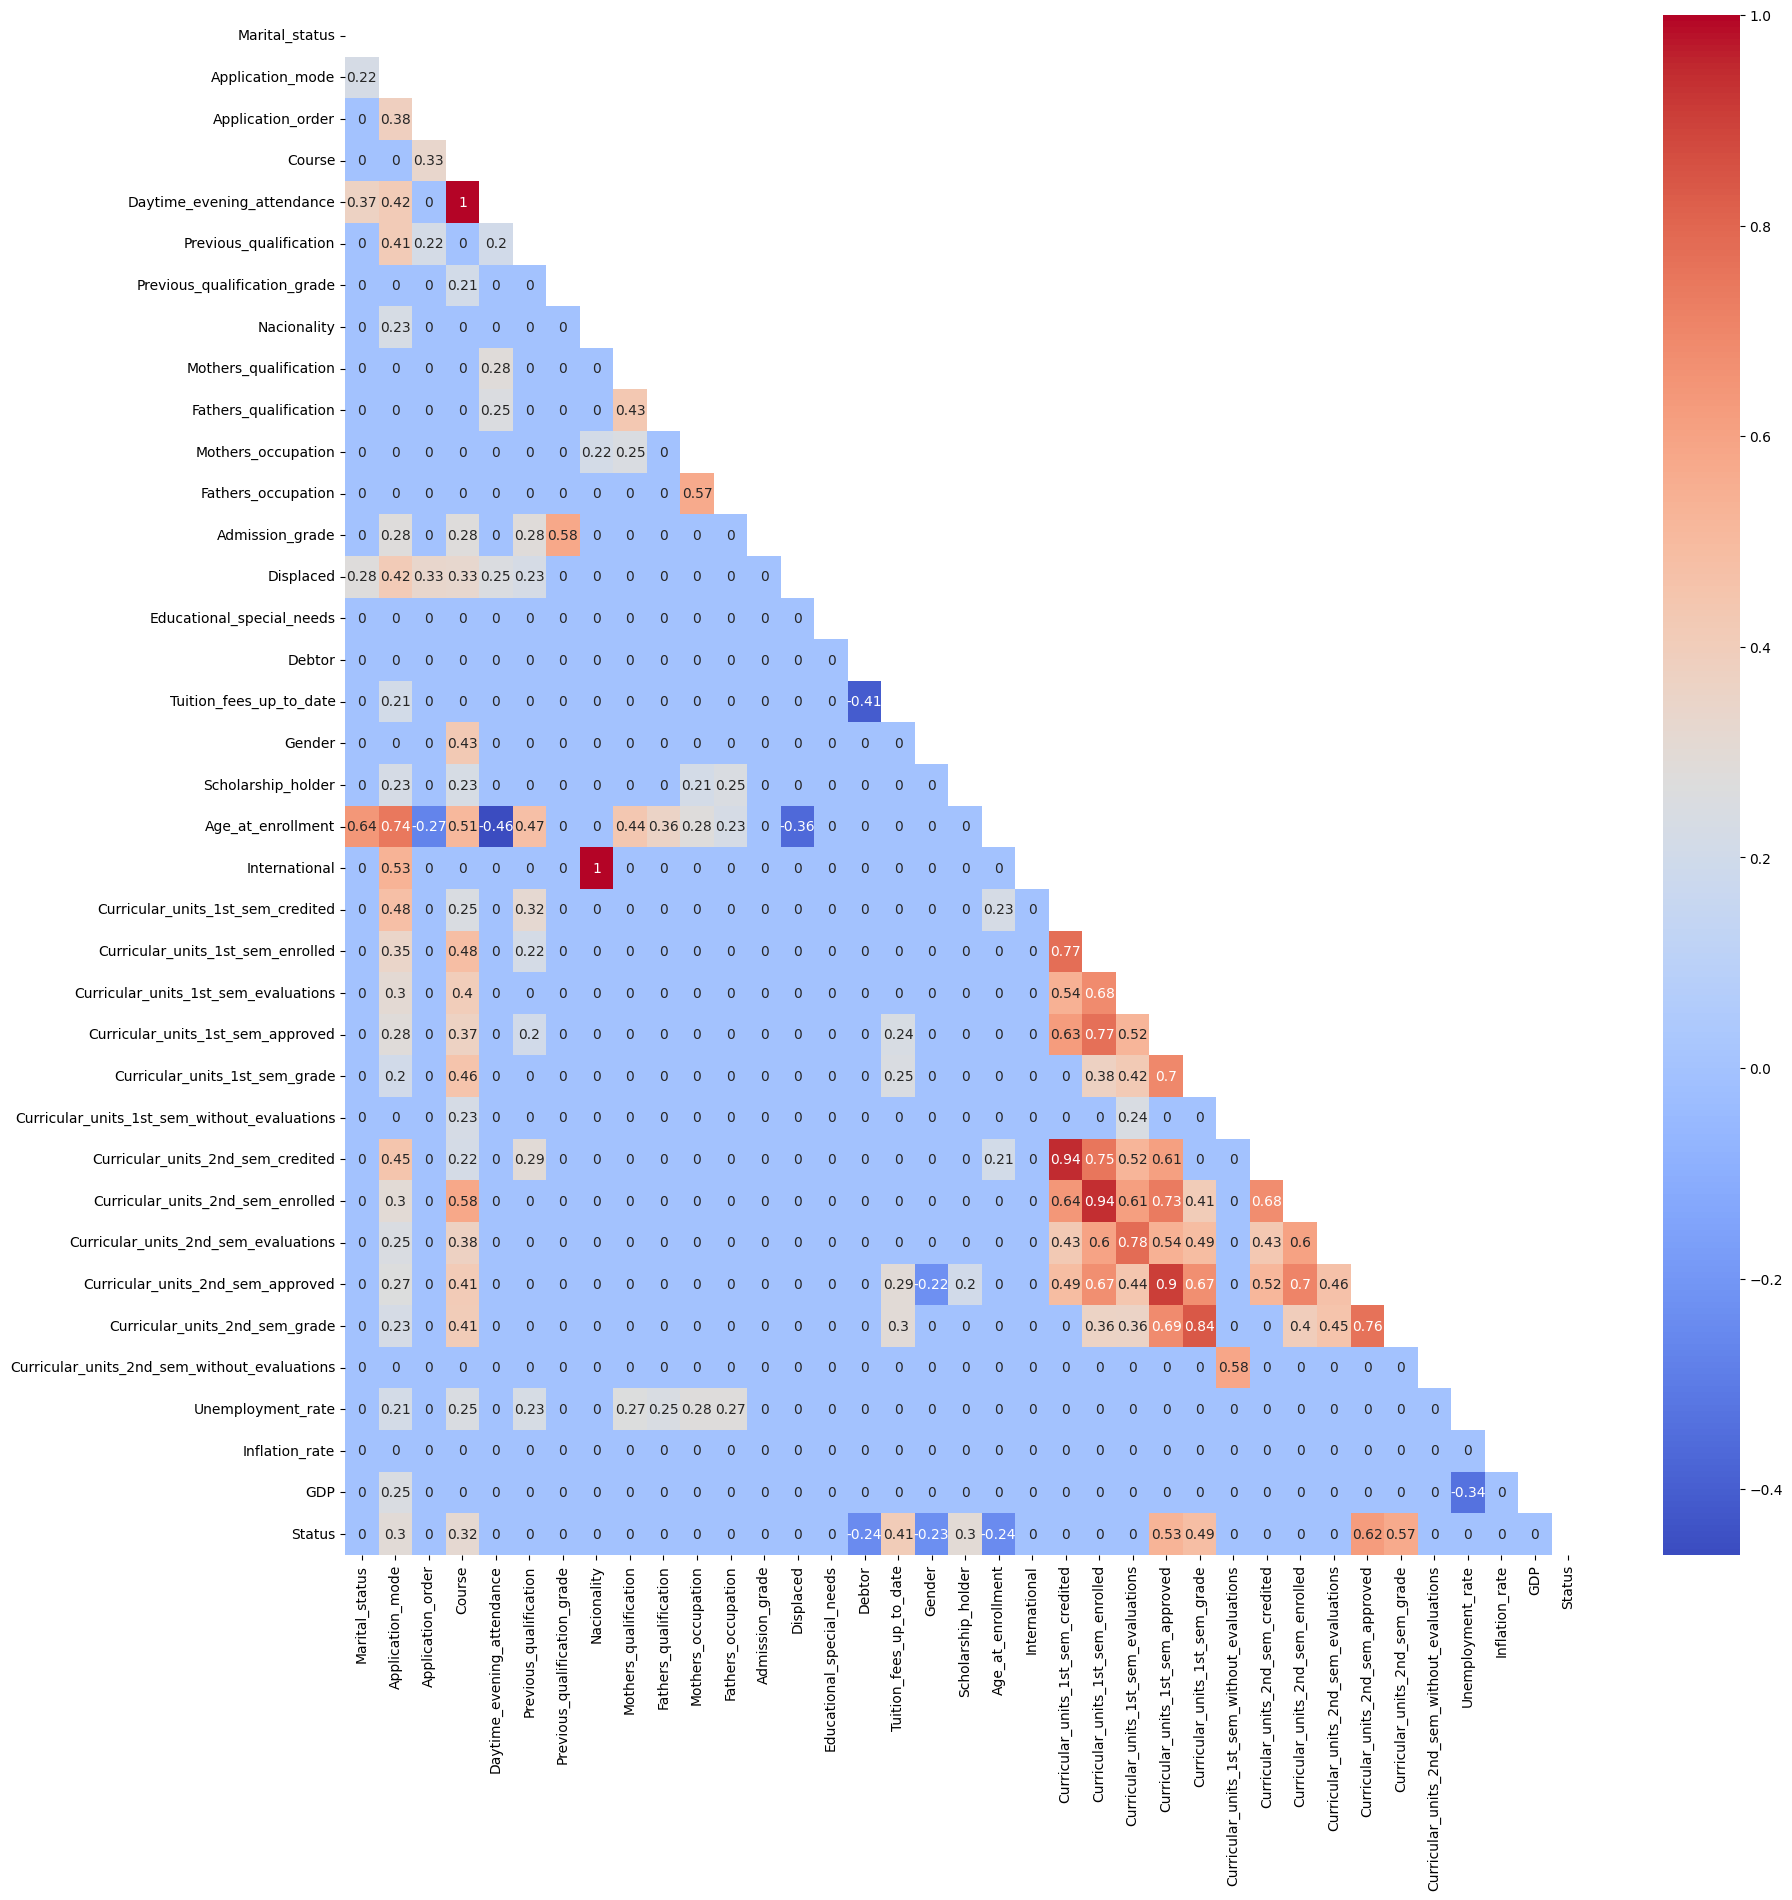

In [88]:
# Dropout status can also be made as ordinal
temp = df.replace({'Status': {
    'Dropout': '0',
    'Enrolled': '1',
    'Graduate': '2'
}})

temp['Status'] = temp['Status'].astype('int')
temp = assoc_matrix(temp, cat_col, corr_type)

# For the next cell (no threshold filter)
temp2 = temp.copy()
# Show only strongly correlated columns
# Use with caution since there are different metrics
thres = 0.2
temp[(temp > 0) & (temp < thres)] = 0
temp[(temp < 0) & (temp > -thres)] = 0

plt.figure(figsize = (20, 20))

# Generate only the bottom triangle (not for Theil's U)
mask = np.triu(np.ones_like(temp.corr(), dtype = bool))
mask = mask if corr_type != 'theil' else 0

sns.heatmap(temp, cmap = 'coolwarm', annot = True, mask = mask)
plt.show()

As you can see above, some columns also have strong multicolinearity with each other (e.g. curricular units, parents' occupation)

However, categorical features association (e.g. Cramer's V) oftenly can't be interpreted directly like Pearson's R. Here are some references:
- https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 (mushroom odor & poisonousity, Cramer's V vs Theil's U)
- https://stats.stackexchange.com/questions/339577/interpreting-cramers-v-results (profession & neighborhood)
- https://www.peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2c-Effect-Size.html (Cramer's V interpretation table)
- https://rcompanion.org/handbook/H_10.html (another Cramer's V interpretation table)

**Example metric scores:**

| Metric | Father-Mother Occupation | Mother (Unskilled Worker)-Nationality | Mother (All Occupations)-Nationality | Course-Attendance | Marital Status-Attendance | Admission-Prev. Qual. Grade |
| --- | --- | --- | --- | --- | --- | --- |
| Cramer's V | 0.57 | 0.039 | 0.22 | 1 | 0.37 (corr. ratio) | 0.58 (Pearson's R) |
| Theil's U | 0.21 / 0.25 |0 / 0.021 | 0.011 / 0.13 | 1 | 0.37 (corr. ratio) | 0.58 (Pearson's R) |
| Phi-K | 0.96 | 0.045 | 0.65 | 1 | 0.51 | 0.81 |

**Manual analysis:**
- 1752 / 4424 parents (39%) have the same occupation
- Association between nationality and unskilled worker as mother occupation (boolean, temporary column):
    - 34% (1527 / 4314) of mothers in Portuguese are unskilled workers
    - 52% (20 / 38) of mothers in Brazil are unskilled workers
    - 38% (5 / 13) of mothers in Cape Verdean are unskilled workers
    - 50% (7 / 14) of mothers in Santomean are unskilled workers
    - 30% (4 / 13) of mothers in Spanish are unskilled workers, and so on
    - The average is 42% (880% / 21) from all percentages above,  but the real value is 35% (1577 / 4424) mothers are unskilled workers
- Mother (unskilled worker) and mother (all occupations) have a relatively big gap in metric scores, despite unskilled worker is the most common one
- Only 2 courses have evening attendance and the rest is always daytime, so it kinda make sense that the association score is 1
    - Perfect score (1) for nationality-international as well, so it means all metrics understood constant association well
- As for marital status-attendance:
    - 93% (3649 / 3919) single took daytime attendance
    - 59% (54 / 91) divorced took daytime attendance
    - 84% (21 / 25) facto union took daytime attendance
    - 33% (2 / 6) separated took daytime attendance
    - 55% (212 / 379) married took daytime attendance
    - 75% (3 / 4) widowed took daytime attendance
    - The average is 66% (399% / 5) from all percentages above, but the real value is 89% took daytime attendance

**Conclusions:**
- Cramer's V seems to be more balanced (not too low or high) compared to Theil's U and Phi-K
- Theil's U asymmetric nature may be useful in some cases (based on nationality, we can slightly guess the mother's occupation, but not the other way)
- Phi-K consistently have higher scores compared to all other metrics
- For my use case later, i.e. eliminating multicollinearity and useless features, Cramer's V or Theil's U is more preferable

Next, we can also focus on the direct correlation with status column (since matrix values above are already filtered)

In [89]:
temp = temp2[['Status']]
temp = temp.sort_values(by = 'Status', ascending = False)

# See direct correlation with target column only
temp.style.background_gradient(cmap = 'coolwarm', axis = None)

,Status
Status,1.000000
Curricular_units_2nd_sem_approved,0.624157
Curricular_units_2nd_sem_grade,0.566827
Curricular_units_1st_sem_approved,0.529123
Curricular_units_1st_sem_grade,0.485207
Tuition_fees_up_to_date,0.409827
Course,0.319606
Scholarship_holder,0.297595
Application_mode,0.297205
Fathers_qualification,0.187610


The strong features can be used as initial hypotheses, while the weak ones can be removed later before ML training

### 3.3. Export to Supabase

Create a Supabase project first, go to project settings - database, and copy connection string to `database.txt`

Notice that `data/data_categorical.csv` is used instead

In [90]:
# Export dataframe to Supabase/local SQL server
export_database = False

with open('database.txt') as f:
    database_url = f.readline()
    # print(database_url)
    engine = sqa.create_engine(url = database_url)

if export_database:
    # Use the categorical version for dashboard
    temp = pd.read_csv('data/data_categorical.csv', sep = ';')
    temp.to_sql('student', engine, index = False, if_exists = 'replace')

## 4. Modeling

### 4.1. Model Preprocessing

#### 4.1.1. Convert Target Column to Numeric
All other columns don't need to be converted to numerical again since they are only exported as `data_categorical.csv` for dashboard, not as `df` variable

In [91]:
df = df.replace({'Status': {
    'Dropout': '0',
    'Enrolled': '1',
    'Graduate': '2'
}})

df['Status'] = df['Status'].astype('int')
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


Cross check that there is no object/categorical data types

In [92]:
# print(df.dtypes)

#### 4.1.2. Feature Engineering
Useless features and features that are strongly correlated with each other (multicollinearity) can be removed or subsituted ([reference about multicolinearity](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b))

Other keywords related to feature engineering: feature selection, feature extraction, etc ([reference](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)). Mostly also included in `sklearn` library

First, we will remove unimportant values that have direct weak correlation with dropout status (uncomment/see section 3.2 for full rows)

In [93]:
temp = assoc_matrix(df, cat_col, corr_type)
temp = temp[['Status']].sort_values(by = 'Status', ascending = False)

# Minimum correlation score to be filtered
# Values less than this will be removed
thres = 0.2
col = temp[(temp['Status'] >= thres) | (temp['Status'] <= -thres)].index
col = [c for c in temp.index if c not in col]

print('Kept columns (see full & colored rows from section 3.2):')
display(temp[~temp.index.isin(col)])

print('Removed columns (weak correlation with dropout status):')
display(temp[temp.index.isin(col)])
df.drop(col, axis = 1, inplace = True)

Kept columns (see full & colored rows from section 3.2):


,Status
Status,1.000000
Curricular_units_2nd_sem_approved,0.624157
Curricular_units_2nd_sem_grade,0.566827
Curricular_units_1st_sem_approved,0.529123
Curricular_units_1st_sem_grade,0.485207
Tuition_fees_up_to_date,0.409827
Course,0.319606
Scholarship_holder,0.297595
Application_mode,0.297205
Gender,-0.229270


Removed columns (weak correlation with dropout status):


,Status
Fathers_qualification,0.187610
Previous_qualification,0.186805
Mothers_qualification,0.182681
Curricular_units_2nd_sem_enrolled,0.175847
Mothers_occupation,0.175179
Fathers_occupation,0.166478
Curricular_units_1st_sem_enrolled,0.155974
Admission_grade,0.120889
Displaced,0.113986
Marital_status,0.108097


Then we check the correlation matrix again after removing some columns

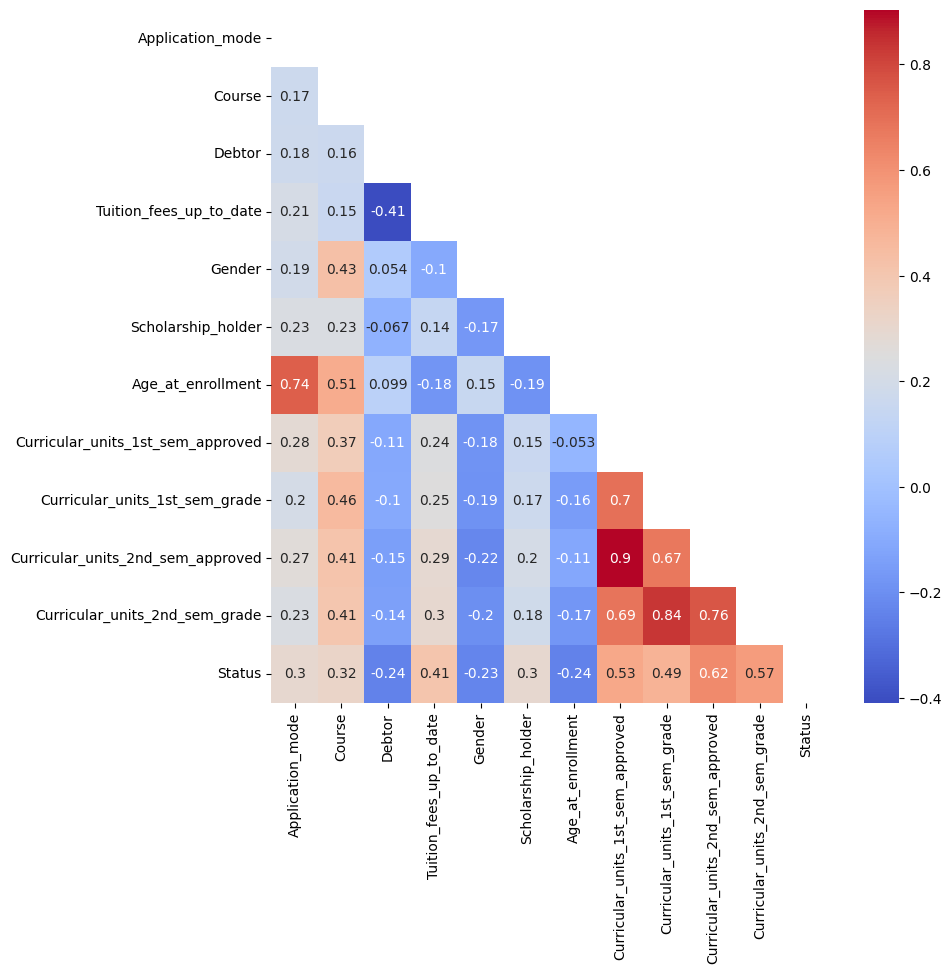

In [94]:
temp = assoc_matrix(df, cat_col, corr_type)

plt.figure(figsize = (9, 9))

# Generate only the bottom triangle (not for Theil's U)
mask = np.triu(np.ones_like(temp.corr(), dtype = bool))
mask = mask if corr_type != 'theil' else 0
sns.heatmap(temp, cmap = 'coolwarm', annot = True, mask = mask)

plt.show()

Compute the VIF (Variance Inflation Factor) to see the multicollinearity of each variable (not just between 2 variables)

VIF above 5 is often considered abnormal (too strongly correlated) and need to be removed or substituted

**Note 1:** VIF is originally designed for Pearson's R only, combining it with Cramer's V/Theil's U to get categorical multicollinearity may be theorically wrong

**Note 2:** Other than VIF, we can use PCA or other algorithms as well ([example reference](https://machinelearningmastery.com/feature-selection-machine-learning-python/)). See important keywords at the beginning of section 4.1.2 too

In [95]:
temp = df.copy()

# Modified from https://stackoverflow.com/a/51463149
# May be wrong to use mixed matrix though (see markdown cell above)

def compute_vif(df: pd.DataFrame, cat_col: list) -> pd.DataFrame:
    # col_ex = [c for c in df.columns if c not in cat_col]
    # cc = np.corrcoef(df[col_ex], rowvar = False)
    cc = assoc_matrix(df, cat_col, corr_type)

    vif = np.linalg.inv(cc).diagonal()
    df = pd.DataFrame({'vif': vif}, index = df.columns)
    return df.sort_values(by = 'vif', ascending = False)

compute_vif(temp, cat_col)

,vif
Curricular_units_2nd_sem_approved,8.292944
Curricular_units_1st_sem_approved,6.687271
Curricular_units_2nd_sem_grade,4.854490
Curricular_units_1st_sem_grade,3.960214
Status,1.774375
Tuition_fees_up_to_date,1.266287
Debtor,0.973579
Scholarship_holder,0.927673
Gender,0.768323
Course,0.061776


Test by removing variables with VIF score above 5 one-by-one (not all at once), until all VIF scores are below 5

Instead of directly removing, we can also try combining/substituting the features ([reference](https://www.kaggle.com/code/gabrielebosi/university-dropout-prediction-model))

~~**TODO:** Compare the effect difference between addition and multiplication~~ multiplication is better

In [96]:
# Copy the dataframe since this is only a test
# The real modification starts on the next cell
temp = df.copy()

temp['Curricular_units_all_sem_approved'] = temp['Curricular_units_1st_sem_approved'] * temp['Curricular_units_2nd_sem_approved']
temp.drop(['Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_approved'], axis = 1, inplace = True)
# Compute everytime before removing next variable (to see the effect)
# compute_vif(temp, cat_col)

temp['Curricular_units_all_sem_grade'] = temp['Curricular_units_1st_sem_grade'] * temp['Curricular_units_2nd_sem_grade']
temp.drop(['Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_grade'], axis = 1, inplace = True)
compute_vif(temp, cat_col)

,vif
Status,1.664946
Curricular_units_all_sem_grade,1.588057
Curricular_units_all_sem_approved,1.339693
Tuition_fees_up_to_date,1.237077
Debtor,0.953941
Scholarship_holder,0.903969
Gender,0.762878
Course,0.067152
Application_mode,-0.114179
Age_at_enrollment,-0.463487


In [97]:
print('Columns before removal:', len(df.columns))

df['Curricular_units_all_sem_approved'] = df['Curricular_units_1st_sem_approved'] * df['Curricular_units_2nd_sem_approved']
df['Curricular_units_all_sem_grade'] = df['Curricular_units_1st_sem_grade'] * df['Curricular_units_2nd_sem_grade']

df.drop(['Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_approved'], axis = 1, inplace = True)
df.drop(['Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_grade'], axis = 1, inplace = True)

print('Columns after removal:', len(df.columns))

Columns before removal: 12
Columns after removal: 10


#### 4.1.3. Train-Test Split

In [98]:
# Redefine categorical columns after removing some
cat_col = [c for c in df.columns if c in cat_col]

# Fix categorical columns data type first before splitting
# Needed for categorical encoder later (will skip numeric columns by default)
df[cat_col] = df[cat_col].astype('category')

In [99]:
x_train, x_test, y_train, y_test = train_test_split(
    df[[c for c in df.columns if c != 'Status']], # x
    df['Status'], # y
    stratify = df['Status'],
    test_size = 0.2,
    shuffle = True,
    random_state = 1337
)

In [100]:
print(x_train.shape)
print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# Check if stratify working correctly
print(y_train.value_counts())
print(y_test.value_counts())

(3539, 9)
(885, 9)
Status
2    1767
0    1137
1     635
Name: count, dtype: int64
Status
2    442
0    284
1    159
Name: count, dtype: int64


In [101]:
# Copy dataframe for experiment purpose (the next few cells)
# The real change will be right before training the models (using pipeline)
x_train_exp = x_train.copy()
y_train_exp = y_train.copy()
x_test_exp = x_test.copy()
y_test_exp = y_test.copy()

#### 4.1.4. Encode Categorical Columns

Current problem:
- Even though the categorical columns have been converted to numeric (label encoded) by default, they still have unclear sort order (e.g. nationality)
- Another commonly used encoding is one hot encoding, but it has the curse of dimensionality and can be heavy to train if there are too many dimensions. It will be a problem too if the test set contains value that is not in train set
- Another popular alternative for one hot encoding is entity embedding or entity resolution, but requires neural network, which can't be used for other types of ML
- If there are only 2 classes then we can use target (mean) encoding. However, for 3 classes or more, mean encoding doesn't really make sense (e.g. if there are 3 classes, 1+1+1 and 0+1+2 will have the same mean)
- Turns out there is another variation of target encoding, i.e. leave one out encoding, which is explained [here](https://mlexplained.blog/2023/06/29/leave-one-out-encoding-encode-your-categorical-variables-to-the-target/) and proven [here](https://brendanhasz.github.io/2019/03/04/target-encoding.html). Even though it still kinda have the same flaw as target encoding (see above), I decided to use it for now

Some references:
- https://brendanhasz.github.io/2019/03/04/target-encoding.html (in-depth comparison between target, one hot, and label encoding)
- https://mlexplained.blog/2023/06/29/leave-one-out-encoding-encode-your-categorical-variables-to-the-target/ (leave one out encoding)
- https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53 (target encoding workaround for multiclass)
- https://www.kaggle.com/competitions/cat-in-the-dat (categorical encoding competition, there is cat-in-the-dat-ii as well, and some people use entity embedding)
- https://towardsdatascience.com/understanding-entity-embeddings-and-its-application-69e37ae1501d (entity embedding in general)
- https://medium.com/peak-product/towards-reusable-entity-resolution-eed1c6ee4a14 (autoencoder and siamese encoder)

In [102]:
# Sigma to add a little noise to the result (reduce overfit)
encoder = ce.LeaveOneOutEncoder(sigma = 0.05, random_state = 1337)
encoder_name = 'loo_encoder'

# Fit on train data only, transform on both train and test data
# To see the mapping between in and out, print "encoder.mapping"
x_train_exp[cat_col] = encoder.fit_transform(x_train_exp[cat_col], y_train_exp)
x_test_exp[cat_col] = encoder.transform(x_test_exp[cat_col])

# with open('model/encoder.lz4', 'wb') as f:
#     joblib.dump(encoder, f)

x_train_exp.head()

,Application_mode,Course,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,Curricular_units_all_sem_approved,Curricular_units_all_sem_grade
1658,0.984061,1.097952,0,1,0,1,20,0,0.000000
2489,1.371242,1.025434,0,1,1,1,20,36,183.928571
432,1.237319,1.023965,0,1,0,1,19,25,166.160000
2318,1.283680,1.334292,0,1,1,0,19,0,0.000000
229,1.030459,1.586916,0,1,0,1,19,49,133.897959


**Note:** When using target/LOO encoder, unknown values on test data (that don't exist during fitting) will be replaced by mean

#### 4.1.5. Data Scaling
Scaling is [not required](https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048) for tree-based models, but might be needed for other models. Doesn't hurt to apply too based on the previous reference

The comparison between scaler can be seen [here](https://medium.com/@hhuseyincosgun/which-data-scaling-technique-should-i-use-a1615292061e), and the effect may [depends on the ML algorithm](https://arxiv.org/pdf/2212.12343) too (see the visualization at the end of preprocessing section)

In [103]:
scaler = Normalizer()
scaler_name = 'l2_normalizer'

# After transforming, it will be numpy instead of dataframe
x_train_exp = scaler.fit_transform(x_train_exp)
x_test_exp = scaler.transform(x_test_exp)

# with open('model/scaler.lz4', 'wb') as f:
#     joblib.dump(scaler, f)

# View again as dataframe (temporarily)
pd.DataFrame(x_train_exp, columns = x_train.columns).head()

,Application_mode,Course,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,Curricular_units_all_sem_approved,Curricular_units_all_sem_grade
0,0.048948,0.054613,0.0,0.049741,0.000000,0.049741,0.994823,0.000000,0.000000
1,0.007275,0.005440,0.0,0.005305,0.005305,0.005305,0.106102,0.190983,0.975757
2,0.007316,0.006055,0.0,0.005913,0.000000,0.005913,0.112350,0.147829,0.982529
3,0.067060,0.069704,0.0,0.052240,0.052240,0.000000,0.992565,0.000000,0.000000
4,0.007163,0.011031,0.0,0.006951,0.000000,0.006951,0.132071,0.340604,0.930740


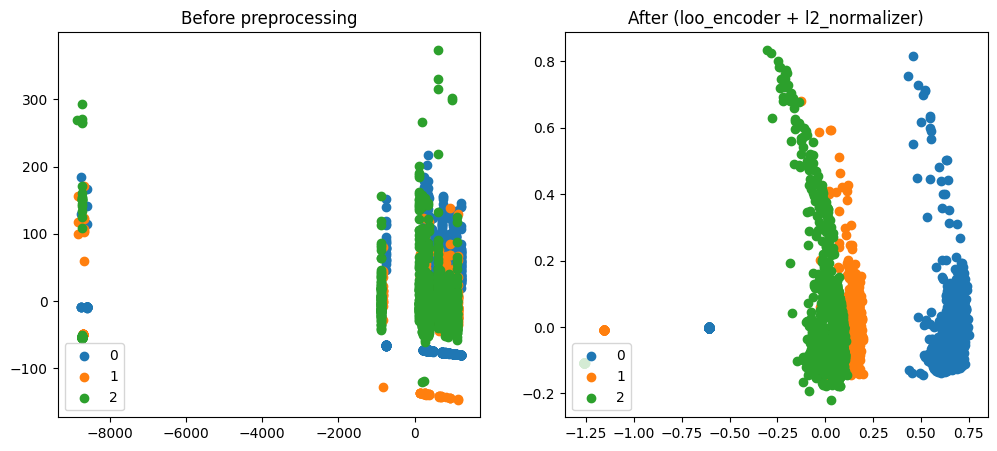

In [104]:
# 2 components for 2D visualization
pca = PCA(n_components = 2, random_state = 42)

# Array of PCA-ed data distributed by target class
# If there are 3 classes then the length is 3
# Before and after preprocessing
list_before = []
list_after = []

target = sorted(y_train_exp.unique())

for t in target:
    list_before.append(
        # PCA should return a copy so it's safe
        pca.fit_transform(x_train[y_train == t])
    )

    list_after.append(
        pca.fit_transform(x_train_exp[y_train_exp == t])
    )

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

for i in range(len(list_before)):
    ax1.scatter(
        # 0 and 1 since there are only 2 dimensions
        list_before[i][:,0],
        list_before[i][:,1],
        label = target[i]
    )

for i in range(len(list_after)):
    ax2.scatter(
        list_after[i][:,0],
        list_after[i][:,1],
        label = target[i]
    )

for ax in (ax1, ax2):
    ax.legend(loc = 'lower left')
    if ax == ax1: ax.set_title('Before preprocessing')
    else: ax.set_title(f'After ({encoder_name} + {scaler_name})')

plt.show()

Observation:
- Min-max scaler and max absolute scaler will give a pretty good class separation, but the distribution is weird and extremely non-linear
- Robust scaler pattern is quite bad and maybe not a good choice in this case
- Standard scaler and power transformer have similar results, kinda better than robust scaler but worse than min-max scaler
- Quantile transformer has some similarities with min-max scaler, but forming a line (which make it worse) instead of more concentrated point
- L2 normalizer has the best distribution that can be understood by most models, but there are some considerable overlap between class 1 and 2
- L1 and max normalizer is slightly worse than L2

Verdict:
- Min-max scaler for KNN
- L2 normalizer for the rest of the models?
- Models may perform better if we make it as binary classification, especially if using L2 normalizer

In [105]:
# Delete the experiment variables
# Pipeline will be used next
del x_train_exp
del y_train_exp
del x_test_exp
del y_test_exp

### 4.2. Model Training

Reworked code inspired from this [notebook](https://www.kaggle.com/code/gabrielebosi/university-dropout-prediction-model), but I'm using balanced class weight whenever possible (not using SMOTE)

In [106]:
# Preprocessing steps should have the same seed across models (for reproducibility)
# The models themselves can have different seed though (to prevent same result between similar models)
# Also, scalers usually don't have seed so we don't need the write them here
encoder = ce.LeaveOneOutEncoder(sigma = 0.05, random_state = 12)

models = {
    'svm': {
        'pipe': Pipeline([
            ('encoder', encoder),
            ('scaler', Normalizer()),
            ('model', SVC(random_state = 55))
        ]),
        # https://scikit-learn.org/stable/modules/svm.html#classification
        # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
        'test_params': {
            'model__C': [2, 2.25, 2.5],
            'model__kernel': ['linear', 'poly'],
            'model__gamma': ['scale', 'auto'],
            'model__degree': [2, 3],
            'model__probability': [True],
            'model__class_weight': ['balanced']
        }
    },
    'logistic_regression': {
        'pipe': Pipeline([
            ('encoder', encoder),
            ('scaler', Normalizer()),
            ('model', LogisticRegression(random_state = 34))
        ]),
        # https://scikit-learn.org/stable/modules/linear_model.html#multinomial-case
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        'test_params': {
            'model__C': [1.75, 2, 2.25],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear', 'saga'],
            'model__warm_start': [True],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced']
        }
    },
    'knn': {
        'pipe': Pipeline([
            ('encoder', encoder),
            # Use min-max scaler for KNN
            ('scaler', MinMaxScaler()),
            ('model', KNeighborsClassifier())
        ]),
        # https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification
        # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
        'test_params': {
            'model__n_neighbors': [5, 8, 10],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]
        }
    },
    'random_forest': {
        'pipe': Pipeline([
            ('encoder', encoder),
            ('scaler', Normalizer()),
            ('model', RandomForestClassifier(random_state = 23))
        ]),
        # https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles
        # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        # https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
        'test_params': {
            'model__n_estimators': [50, 75 ,100],
            'model__max_depth': [4],
            'model__criterion': ['entropy'],
            'model__class_weight': ['balanced']
        }
    },
    'xgboost': {
        'pipe': Pipeline([
            ('encoder', encoder),
            ('scaler', Normalizer()),
            ('model', XGBClassifier(random_state = 11))
        ]),
        # https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees
        # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
        'test_params': {
            'model__n_estimators': [50, 75 ,100],
            'model__max_depth': [4],
            'model__learning_rate': [0.025, 0.05, 0.1],
            'model__grow_policy': ['depthwise'],
        }
    }
}

In [107]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
score = 'f1_macro'
# If false, graduate and enrolled will be combined
multiclass = False

Searching best parameters for svm


Search time (seconds): 21.738
Score using training data (mean, cross-validated): 0.797
Score using training data: 0.796
Score using test data: 0.801
Best parameters: {'model__C': 2.5, 'model__class_weight': 'balanced', 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'poly', 'model__probability': True}


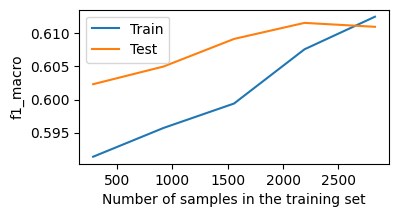

Searching best parameters for logistic_regression
Search time (seconds): 1.602
Score using training data (mean, cross-validated): 0.805
Score using training data: 0.809
Score using test data: 0.814
Best parameters: {'model__C': 2, 'model__class_weight': 'balanced', 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'model__warm_start': True}


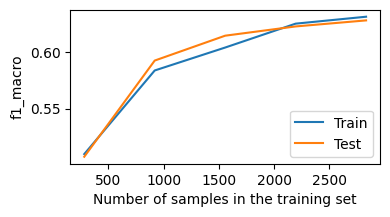

Searching best parameters for knn
Search time (seconds): 0.866
Score using training data (mean, cross-validated): 0.81
Score using training data: 0.839
Score using test data: 0.83
Best parameters: {'model__n_neighbors': 8, 'model__p': 1, 'model__weights': 'uniform'}


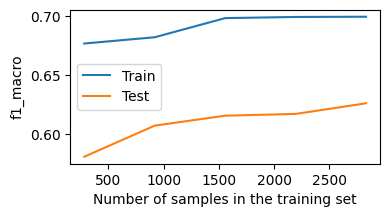

Searching best parameters for random_forest
Search time (seconds): 1.838
Score using training data (mean, cross-validated): 0.824
Score using training data: 0.831
Score using test data: 0.807
Best parameters: {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 4, 'model__n_estimators': 75}


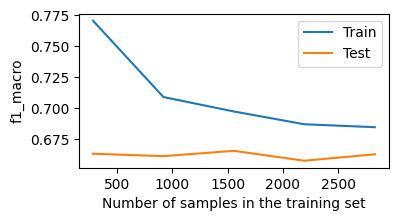

Searching best parameters for xgboost
Search time (seconds): 1.468
Score using training data (mean, cross-validated): 0.827
Score using training data: 0.843
Score using test data: 0.842
Best parameters: {'model__grow_policy': 'depthwise', 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 75}


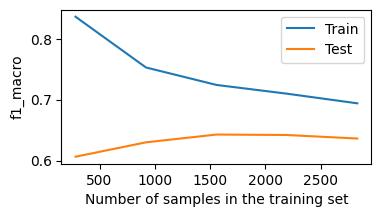

In [108]:
if not multiclass:
    y_train_exp = y_train.replace(2, 1)
    y_test_exp = y_test.replace(2, 1)
else:
    y_train_exp = y_train
    y_test_exp = y_test

for name, config in models.items():
    print(f'Searching best parameters for {name}')
    runtime = time.time()

    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    search = GridSearchCV(
        estimator = config['pipe'],
        param_grid = config['test_params'],
        scoring = score,
        n_jobs = -1
    )

    # Based on the docs, transform is not needed
    search.fit(x_train, y_train_exp)
    models[name]['best'] = search.best_estimator_

    print('Search time (seconds):', round(time.time() - runtime, 3))
    print('Score using training data (mean, cross-validated):', round(search.best_score_, 3))
    print('Score using training data:', round(search.score(x_train, y_train_exp), 3))
    print('Score using test data:', round(search.score(x_test, y_test_exp), 3))
    print('Best parameters:', search.best_params_)

    fig, ax = plt.subplots(figsize = (4, 2))
    LearningCurveDisplay.from_estimator(
        search.best_estimator_,
        x_train,
        y_train,
        scoring = score,
        score_name = score,
        std_display_style = None,
        random_state = 39,
        ax = ax
    )

    plt.show()

Observation:
- SVM with C = 2.5 or above will start to overfit
- For logistic regression:
    - Higher C will require higher max iterations (or it will fail to converge). Score for C higher than 2 will also start to stagnant
    - Surprisingly, linear solver performs better than others, even though the data distribution is not linear (see PCA visualization from prev. section)
- KNN using euclidean and distance weight performs better for multiclass, but manhattan and uniform weight performs better for binary class (need more testings)
- XGBoost is generally better than random forest with similar hyperparameters
- When switching from balanced class weight to normal (by deleting the hyperparameter), the score (usually better) and visualization may change significantly
- Binary classification will result overall higher score (around 80%) compared to multiclass classification (around 70%)

In [31]:
ensemble = VotingClassifier(
    estimators = [ (name, config['best']) for name, config in models.items() ],
    voting = 'soft'
)

ensemble.fit(x_train, y_train_exp)

# Export model for future use
# https://scikit-learn.org/stable/model_persistence.html
with open('model/model.lz4', 'wb') as f:
    joblib.dump(ensemble, f)

runtime = time.time()

print('Using ensemble (combined) model')
print('Score using training data:', round(ensemble.score(x_train, y_train_exp), 3))
print('Score using test data:', round(ensemble.score(x_test, y_test_exp), 3))
print('Time needed to score both data (seconds):', round(time.time() - runtime, 3))

Using ensemble (combined) model
Score using training data: 0.865
Score using test data: 0.861
Time needed to score both data (seconds): 0.526


## 5. Evaluation

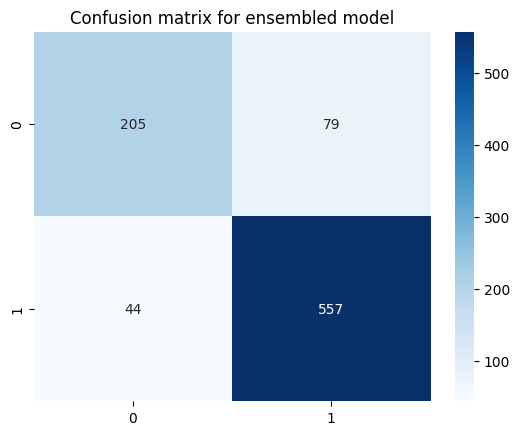

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       284
           1       0.88      0.93      0.90       601

    accuracy                           0.86       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.86      0.86      0.86       885



In [33]:
y_pred = ensemble.predict(x_test)
cm = confusion_matrix(y_test_exp, y_pred)

sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion matrix for ensembled model')
plt.show()

print(classification_report(y_test_exp, y_pred))

As expected, when `multiclass = True`, all scores will drop because the model fail to distinguish class 1 (enrolled) from class 2 (graduate)

Result will be much better if `multiclass = False` (binary classification)

## 6. Misc

Changelog/progress:
- v1: Initial using target encoder, dropout as binary classification (enrolled + graduate = same class)
- v2: Switch again to multiclass classification, experiment by removing multicolinearity (target encoder + Pearson's R matrix + VIF)
- v3: Drop target encoding before correlation matrix (do it after), then switch to mixed correlation matrix (Pearson's R, Cramer's V, correlation ratio)
- v4: Some rework, and introduce Phi-K as optional (switchable) correlation matrix metric
- v5: Switch to leave one out encoder, fix test data leakage by moving encoder after train-test split
- v6: Rework VIF to be able to use metric other than Pearson's R (may be theorically wrong)
- v7: Rework to use pipeline for model and preprocessing instead of procedural (manually calling each functions). Also allow binary classification again (toggleable)

Todo:
- Explore entity embedding for multiple variables
- ~~Experiment with feature interaction and it's effect (+-/*)~~ Multiplication is better than addition, the rest are not tested
- ~~Add cross validation and make it work with target/LOO encoding on each split~~
- Explore linear regression variants (ridge, lasso, etc), ~~and also random forest vs gradient boost~~
- Rework `DecisionBoundaryDisplay` to be able to plot boundary when there are more than 2 features

Note to future self:
- Feature engineering is fun but usually not worth the time, and only has minimal impact on accuracy (can even make it worse). See other notebook for comparison ([Kaggle](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention))